# Проект: Предсказание увольнений сотрудников.

**Описание проекта**: Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. 

**Цель проекта**: У данного проекта будут две задачи: 
- Построить модель, которая предскажет уровень удовлетворенности сотрудников.
- Построить модель, которая предскажет сотрудников, которые уволятся.

**Ход работы**:

**Первая задача**:
- [Загрузка и первичное изучение данных](#upload1)
- [Предобработка данных](#prep1)
- [Исследовательский анализ](#research1)
- [Корреляционный анализ](#corr1)
- [Подготовка данных к машинному обучению](#ml_prep1)
- [Обучение моделей](#mlearning1)
- [Промежуточные выводы для первой задачи](#results1)

**Вторая задача**:
- [Загрузка и первичное изучение данных](#upload2)
- [Предобработка](#prep2)
- [Исследовательский анализ](#research2)
- [Добавление нового признака ко входным данным](#merge)
- [Подготовка данных к машинному обучению](#ml_prep2)
- [Обучние моделей](#mlearning2)

**Итоговые выводы**:
- [Итоговые выводы](#results)

## Задача 1

<a id='upload1'></a>
### Загрузка данных

Для начала импортируем все инструменты и библиотеки, которые нам понадобятся по ходу проекта:

In [1]:
!pip install matplotlib==3.5.0 scikit-learn==1.1.3 numpy==1.23.5 pandas==1.5.3

import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
!pip install phik
import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

     |████████████████████████████████| 11.2 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 86.6 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 59.5 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 85.0 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 924 kB/s  eta 0:00:01
     |████████████████████████████████| 4.8 MB 49.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling 

Для удобства, напишем функцию для подгрузки данных:

In [2]:
def upload_function(data, sep, decimal):
    try:
        info = pd.read_csv(f'/datasets/{data}.csv', sep=sep, decimal=decimal)
    except: 
        info = pd.read_csv(f'https://code.s3.yandex.net/datasets/{data}.csv', sep=sep, decimal=decimal)
    return info

Приступим к загрузке данных:

In [3]:
train_job = upload_function('train_job_satisfaction_rate', ',', ',') # Тренировочный датасет
test_features = upload_function('test_features', ',', ',') # Входные признаки тестовой выборки
test_target_job = upload_function('test_target_job_satisfaction_rate', ',', ',') # Ответы тестовой выборки

Окинем быстрым взглядом подгруженные данные через метод *info*:

In [4]:
display(train_job)
train_job.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   job_satisfaction_rate  4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [5]:
display(test_features)
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [6]:
print(test_target_job.head())
test_target_job.info()

       id job_satisfaction_rate
0  130604                  0.74
1  825977                  0.75
2  418490                   0.6
3  555320                  0.72
4  826430                  0.08
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   job_satisfaction_rate  2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


На первый взгляд, все не так плохо - есть немного пропусков в первых двух датасетах и рейтинг удовлетворенности работой везде имеет не числовой, а строковой формат. Со всем этим будем разбираться далее, в предобработке данных.

<a id='prep1'></a>
### Предобработка данных

Датасет train_job:

In [7]:
train_job.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [8]:
train_job['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [9]:
train_job['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Есть пропуски в столбцах с уровнем и должностью. Позже, при создании  пайплайнов, они будут заполнены.

In [10]:
train_job.duplicated().sum()

0

In [11]:
train_job.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [12]:
cat_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'] 

for i in cat_col:
    print(i, train_job[i].unique())

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Исправим грамматическую ошибку:

In [13]:
train_job.loc[train_job['level']=='sinior', 'level'] = 'senior'
train_job['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

Явных и неявных дубликатов нет, приведем столбец с рейтингом удовлетворенности к числовому виду:

In [14]:
train_job['job_satisfaction_rate'] = train_job['job_satisfaction_rate'].astype('float64')
display(train_job)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


Датасет *test_features*:

In [15]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Пропуски в тех же самых столбцах, по ходу проекта будут заполнены в пайплайне.

In [16]:
test_features.duplicated().sum()

0

In [17]:
for i in cat_col:
    print(i, test_features[i].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [18]:
test_features.loc[test_features['level']=='sinior', 'level'] = 'senior'
test_features['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

А вот и неявные пропуски. Заменим их на значение *np.nan*, чтобы в пайплайнах они ушли:

In [19]:
test_features['dept'] = test_features['dept'].replace({' ': np.nan})
test_features['workload'] = test_features['workload'].replace({' ': np.nan})
for i in cat_col:
    print(i, test_features[i].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level ['junior' 'middle' 'senior' nan]
workload ['medium' 'low' 'high' nan]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Датасет *test_target_job*:

In [20]:
test_target_job.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [21]:
test_target_job.duplicated().sum()

0

In [22]:
test_target_job['job_satisfaction_rate'] = test_target_job['job_satisfaction_rate'].astype('float64')
test_target_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Предобработка данных закончена. В датасетах *train_job* и *test_features* оказались пропуски в столбцах должностей и уровня должности. Столбец с оценкой удовлетворенности в датасетах *train_job* и *test_target_job* был приведен из строкового формата в числовой. Также, в датасете *test_features* были обнаружены неявные пропуски в виде пробелов, которые были заменены на неопределенные значения *np.nan*, для последующего заполнения в пайплайне.

<a id='research1'></a>
### Исследовательский анализ

Приступим к исследовательскому анализу.

Датасет *train_job*:

In [23]:
for i in train_job.drop('id', axis=1).columns:
    print(i, '\n', train_job[i].describe(), '\n\n')

dept 
 count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object 


level 
 count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object 


workload 
 count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object 


employment_years 
 count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 


last_year_promo 
 count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object 


last_year_violations 
 count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object 


supervisor_evaluation 
 count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: superviso

In [24]:
discr_tj = []
cont_tj = []

for i in train_job.drop('id', axis=1).select_dtypes(include='number'):
    print(i, train_job[i].unique())
    if train_job[i].nunique() > 20 or any(train_job[i] % 1 != 0):
        cont_tj.append(i)
    else:
        discr_tj.append(i)
print(discr_tj, '\n', cont_tj)

employment_years [ 2  1  4  7  9  6  3 10  8  5]
supervisor_evaluation [1 5 2 3 4]
salary [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
job_satisfaction_rate [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91
 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53
 0.84 0.52 0.24 0.62 0.41 0.28 0.09 0.97 0.83 0.25 0.43 0.04 0.13 0.29
 0.95 0.93 0.87 0.08 0.94 0.07 0.34 0.9  0.12 0.

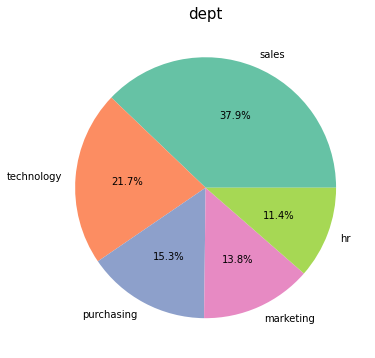

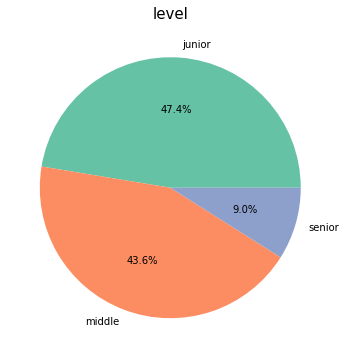

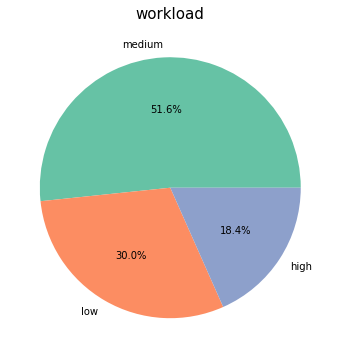

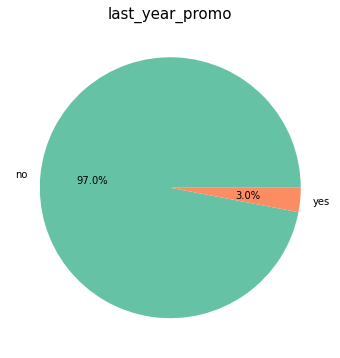

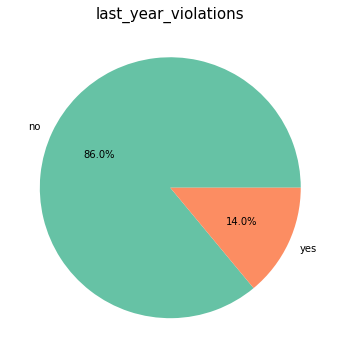

In [25]:
for i in cat_col:
    plt.figure(figsize=(6,6))
    plt.pie(train_job[i].value_counts(), 
            labels=train_job[i].value_counts().index,
            autopct='%1.1f%%',
            colors=plt.cm.Set2.colors
           )
    plt.title(i, fontsize=15)
    plt.show()

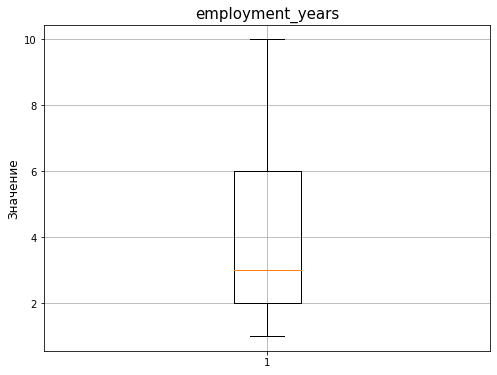

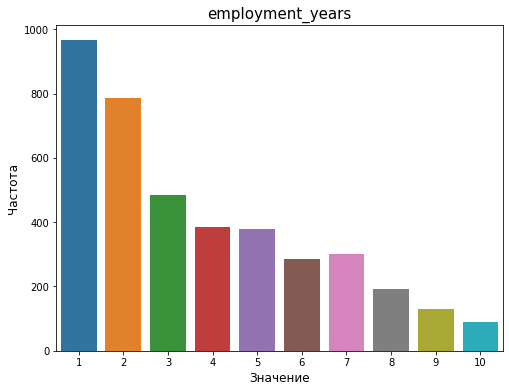

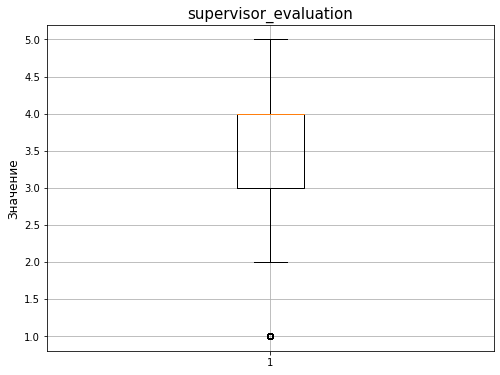

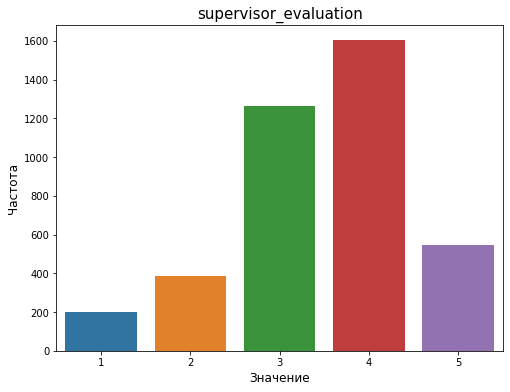

In [26]:
for i in discr_tj:
    plt.figure(figsize=(8,6))
    plt.boxplot(train_job[i])
    plt.grid()
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.countplot(data=train_job, x=i)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

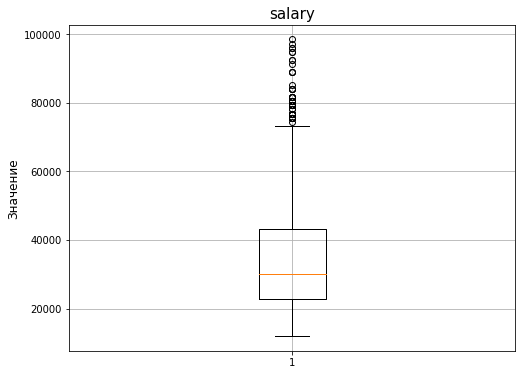

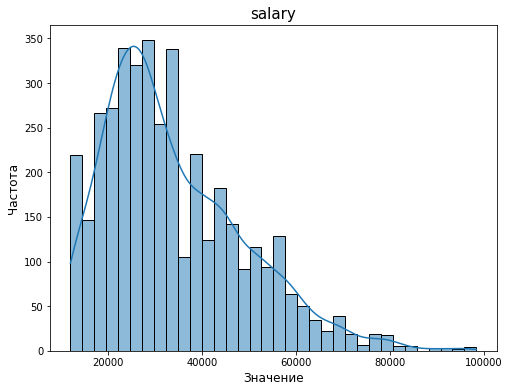

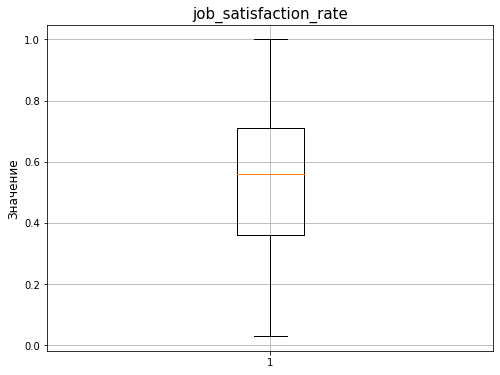

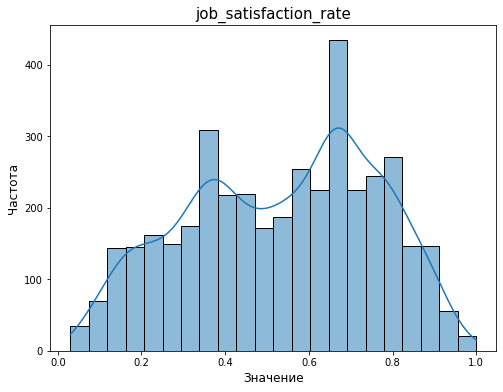

In [27]:
for i in cont_tj:
    plt.figure(figsize=(8,6))
    plt.boxplot(train_job[i])
    plt.grid()
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.histplot(data=train_job, x=i, kde=True)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

Датасет *test_features*:

In [28]:
for i in test_features.drop('id', axis=1).columns:
    print(i, '\n', test_features[i].describe(), '\n\n')

dept 
 count      1997
unique        5
top       sales
freq        763
Name: dept, dtype: object 


level 
 count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object 


workload 
 count       1999
unique         3
top       medium
freq        1043
Name: workload, dtype: object 


employment_years 
 count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 


last_year_promo 
 count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object 


last_year_violations 
 count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object 


supervisor_evaluation 
 count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: superviso

In [29]:
discr_tf = []
cont_tf = []

for i in test_features.drop('id', axis=1).select_dtypes(include='number'):
    print(i, test_features[i].unique())
    if test_features[i].nunique() > 20 or any(test_features[i] % 1 != 0):
        cont_tf.append(i)
    else:
        discr_tf.append(i)
print(discr_tf, '\n', cont_tf)

employment_years [ 2  1  5  6  3  9  7  4  8 10]
supervisor_evaluation [5 4 3 1 2]
salary [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]
['employment_years', 'supervisor_evaluation'] 
 ['salary']


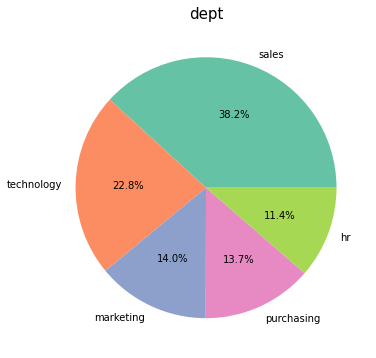

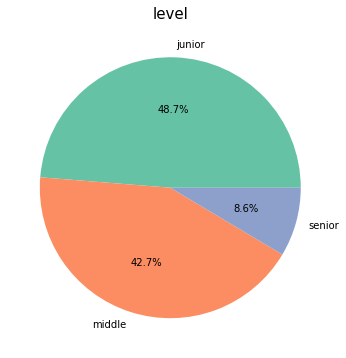

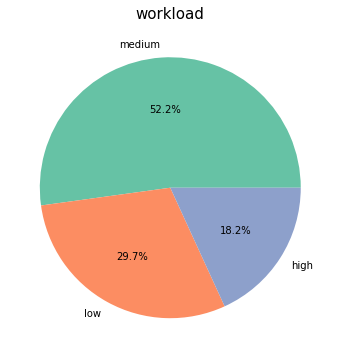

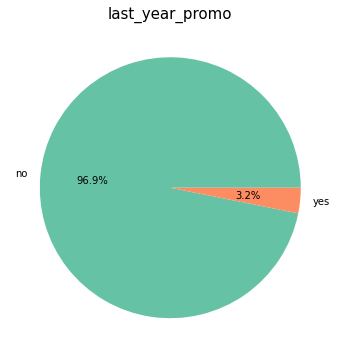

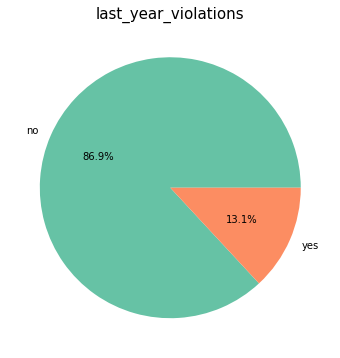

In [30]:
for i in cat_col:
    plt.figure(figsize=(6,6))
    plt.pie(test_features[i].value_counts(),
            labels=test_features[i].value_counts().index,
            autopct='%1.1f%%',
            colors=plt.cm.Set2.colors
           )
    plt.title(i, fontsize=15)
    plt.show()

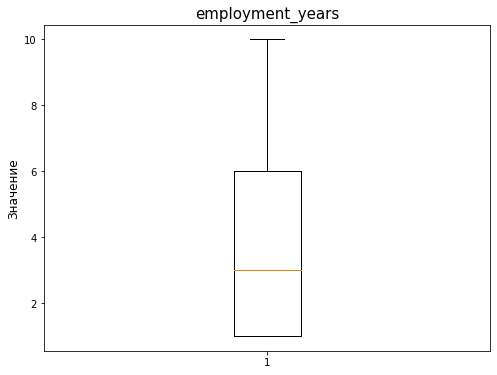

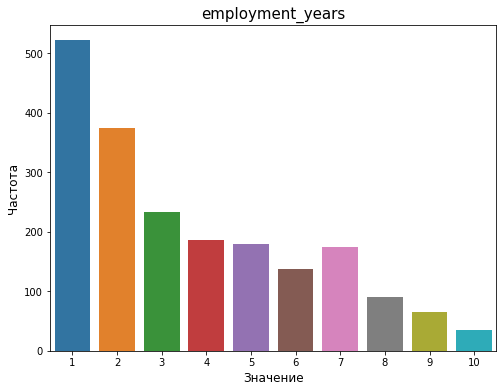

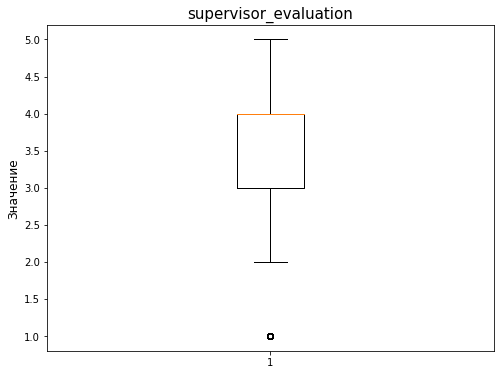

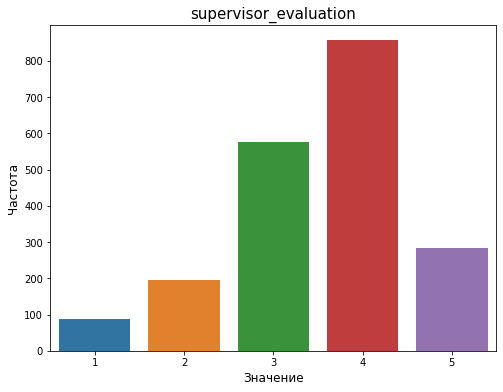

In [31]:
for i in discr_tf:
    plt.figure(figsize=(8,6))
    plt.boxplot(test_features[i])
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(8,6))
    sns.countplot(data=test_features, x=i)
    plt.title(i, fontsize=15)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

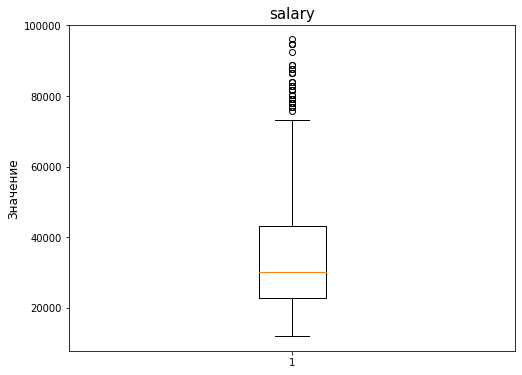

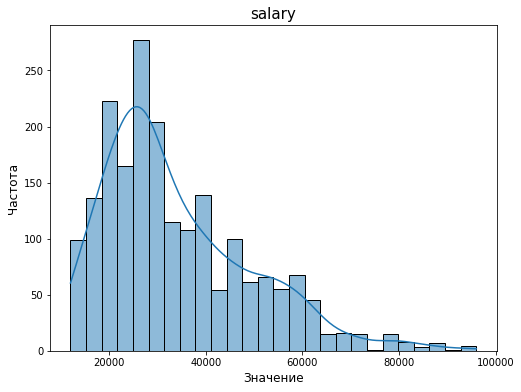

In [32]:
for i in cont_tf:
    plt.figure(figsize=(8,6))
    plt.boxplot(test_features[i])
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(8,6))
    sns.histplot(data=test_features, x=i, kde=True)
    plt.title(i, fontsize=15)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

Датасет *test_target_job*:

In [33]:
test_target_job['job_satisfaction_rate'].describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

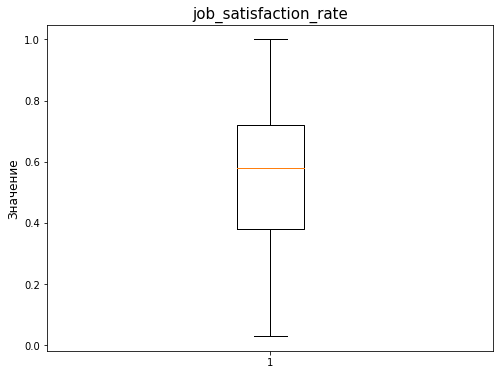

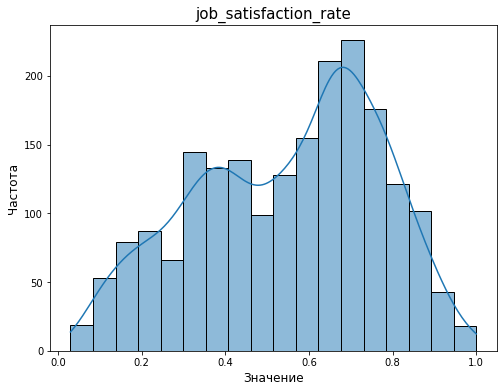

In [34]:
plt.figure(figsize=(8,6))
plt.boxplot(test_target_job['job_satisfaction_rate'])
plt.title('job_satisfaction_rate', fontsize=15)
plt.ylabel('Значение', fontsize=12)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(data=test_target_job, x='job_satisfaction_rate', kde=True)
plt.title('job_satisfaction_rate', fontsize=15)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()

**Промежуточные выводы**:

Датасет *train_job*:

*Качественные признаки*:
- Больше всего людей работает в продажах, на втором месте технологи.
- Всего лишь 9% людей имеют уровень сеньора, уровни джуниор и миддл распределены почти поровну (*junior: 47.5%*, *middle: 43.6%*).
- Большинство людей имеют средний уровень загруженности.
- Только 3% людей получили повышение в прошлом году.
- 14% людей нарушали трудовой договор за прошедший год.

*Количественные дискретные признаки*:
- Средний срок работы в компании равен почти 4 годам, максимальный срок - 10 лет.
- Средняя оценка от руководителей составляет 3.5

*Количественные непрерывные признаки*:
- Средняя зарплата составляет почти 34 000, есть небольшое количество выбросов в большой зарплате, в районе 98 000 (полагаю, что это зарплата того маленького количества сеньоров).
- Средняя оценка удовлетворенности работой близка к 0.6, выбросов в очень маленькую или очень большую сторону не наблюдается.

Датасет *test_features*:
- Распределение всех признаков в датасете *test_features* аналогично распределению признаков в *train_job*/

Датасет *test_target_job*:
- Распределение аналогично соответствующему распределению в *train_job*.

<a id='corr1'></a>
### Корреляционный анализ.

Проведем корреляционный анализ первых двух датасетов, чтобы узнать, нет ли мультиколлинеарности среди входных признаков. 

Датасет *train_job*:

<AxesSubplot:>

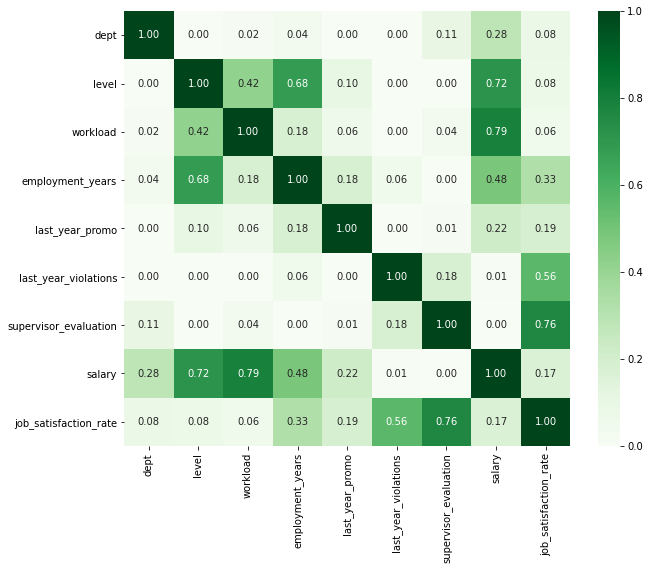

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(train_job.drop(['id'], axis=1).phik_matrix(interval_cols=cont_tj),
           annot=True,
           fmt='.2f',
           cmap='Greens')

Датасет *test_features*:

<AxesSubplot:>

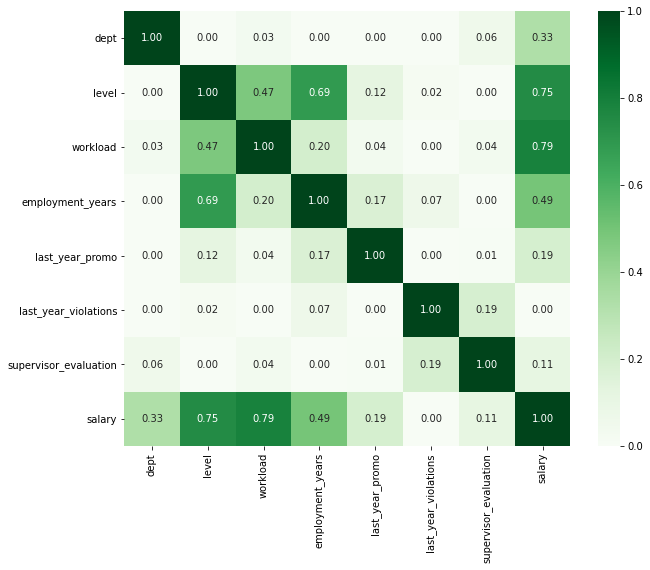

In [36]:
plt.figure(figsize=(10,8))
sns.heatmap(test_features.drop(['id'], axis=1).phik_matrix(interval_cols=cont_tf),
           annot=True,
           fmt='.2f',
           cmap='Greens')

**Промежуточные выводы:**

Видна корреляция между признаками, между которыми её и так можно было бы предположить: 
- Уровень должности коррелирует с количеством лет в компании и с зарплатой.
- Уровень нагрузки коррелирует с зарплатой.
- Есть сильная корреляция оценки от руководителя с целевым признаком удовлетворенности работой.

Не думаю, что какие-либо из этих признаков можно удалить, так мы можем лишиться важных данных, на которые, в последствие, не сможет опираться дерево решений.

<a id='ml_prep1'></a>
### Подготовка данных к машинному обучению.

Займемся пайплайнами:

In [37]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = train_job.drop(['id', 'job_satisfaction_rate'], axis=1).select_dtypes(include='number').columns

Пайплайны для кодировки категориальных признаков:

In [38]:
ohe_pipe = Pipeline([
    ('simpleimputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

In [39]:
ord_pipe = Pipeline([
    ('simpleimputer_beforeOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
        ['junior', 'middle', 'sinior'],
        ['low', 'medium', 'high'],
        ['no', 'yes'],
        ['no', 'yes']
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_afterOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

Пайплайн по подготовке данных:

In [40]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

Финальный пайплайн с деревом решений:

In [41]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Проверим наличие дубликатов в тренировочной выборке после удаления столбца с *id*:

In [42]:
train_job.shape

(4000, 10)

In [43]:
train_job.drop('id', axis=1).duplicated().sum()

245

Появились явные дубликаты, которые составляют менее 10% от всей тренировочной выборки. Их можно удалить:

In [44]:
train_job = train_job.drop_duplicates(subset=train_job.columns.difference(['id'])).reset_index(drop=True)
train_job.shape

(3755, 10)

Создадим список-словарик для последующего поиска гиперпараметров для дерева решений при помощи *RandomizedSearchCV*:

In [45]:
param_grid = [
        {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,51),
        'models__max_features': range(1,51),
        'models__min_samples_leaf': range(1,51),
        'models__min_samples_split': range(1,51),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessoer__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(20,300),
        'models__learning_rate': np.linspace(0.01, 0.3, 20),
        'models__max_depth': range(1,11),
        'models__max_features': range(1,21),
        'models__min_samples_leaf': range(1,31),
        'models__min_samples_split': range(1,31),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Были созданые необходимые пайплайны и инструменты для дальнейшей работы с моделями.

<a id='mlearning1'></a>
### Обучение моделей.

По условию, надо обучить минимум две модели, одна из которых будет линейной, а вторая - деревом решений, причем для дерева решений найти оптимальные гиперпараметры. Проверить это нужно с помощью новой метрики *SMAPE*, введем ее:

In [46]:
def smape(y_true, y_pred):
    score = 100 * (np.abs(y_true - y_pred)) / (0.5 * (np.abs(y_true) + np.abs(y_pred)))
    return score.mean()

SMAPE = make_scorer(smape, greater_is_better=False)

In [47]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=SMAPE, 
    n_jobs=-1
)

In [48]:
X = train_job.drop(['id', 'job_satisfaction_rate'], axis=1)
y = train_job['job_satisfaction_rate']

In [49]:
import warnings
warnings.filterwarnings('ignore')

random_search.fit(X, y)
  
print('Метрика SMAPE, полученная на кросс валидации:', -random_search.best_score_)
print('Лучшая модель и ее параметры:', random_search.best_params_)

# Лучшая метрика SMAPE на дереве решений была равна 17.86 и никак не хотела становится лучше (по условию проекта нужно, чтобы 
# SMAPE <= 15. После чего я не смог придумать ничего лучше, кроме как использовать градиентный бустинг - запретов по этому поводу 
# в условиях не видел.)

Метрика SMAPE, полученная на кросс валидации: 12.14669178614089
Лучшая модель и ее параметры: {'preprocessor__num': 'passthrough', 'models__n_estimators': 176, 'models__min_samples_split': 17, 'models__min_samples_leaf': 2, 'models__max_features': 9, 'models__max_depth': 6, 'models__learning_rate': 0.1931578947368421, 'models': GradientBoostingRegressor(learning_rate=0.1931578947368421, max_depth=6,
                          max_features=9, min_samples_leaf=2,
                          min_samples_split=17, n_estimators=176,
                          random_state=42)}


Посмотрим на метрики моделей на тестовой выборке:

In [50]:
display(test_target_job.head(2))
test_features.head(2)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000


In [51]:
test = test_features.merge(test_target_job, on='id', how='left')
test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [52]:
print('SMAPE на тестовой выборке:', SMAPE._score_func(test['job_satisfaction_rate'], 
                                          random_search.predict(test.drop(['id', 'job_satisfaction_rate'], axis=1))))

SMAPE на тестовой выборке: 11.02612678701029


Лучшее значение SMAPE на кросс-валидации, которое было получено с помощью дерева решений: *17.86*. Ниже ее опустить не получалось никак, перепробовал много сочетаний гиперпараметров. После чего был подключен ансамбль деревьев, который, разумеется, справился лучше - метрика SMAPE на кросс-валидации: *12.14*. 

Поиск гиперпараметров осуществлялся при помощи *RandomizedSearchCV*, для которого был создан словарик в разделе с [подготовкой данных](#ml_prep1).

Посмотрим на распределение остатков для тестового датасета:

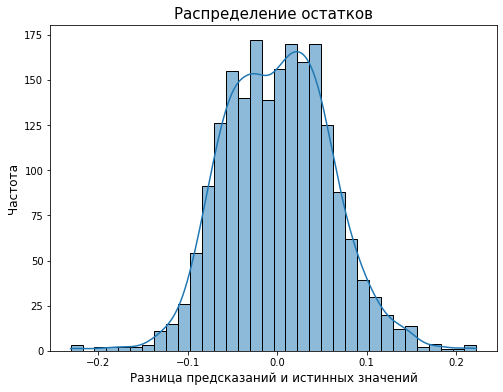

In [53]:
predictions = random_search.predict(test.drop(['id', 'job_satisfaction_rate'], axis=1))
residuals = test['job_satisfaction_rate'] - predictions

plt.figure(figsize=(8,6))
sns.histplot(data=residuals, kde=True)
plt.title('Распределение остатков', fontsize=15)
plt.xlabel('Разница предсказаний и истинных значений', fontsize=12)
plt.ylabel('Частота', fontsize=12);

Остатки распределены нормально, пик в нуле.

<a id='results1'></a>
### Выводы по первой задаче.

Как было показано выше, лучше всего справился ансамбль деревьев (*GradientBoostingRegressor*). Справилась она лучше остальных, думаю, по причине самого своего устройства - это много деревьев решений, каждое из которых обучается на ошибках предыдущего. Линейная регрессия справилась плохо потому, что подходит только для сильных линейных зависимостей, а данные с такими зависимостями, обычно, очень редки. Дерево решений справилось лучше, ее лучшая метрика, полученная на кросс-валидации, была равна *17.86* - хорошее значение, но оно все еще не подходило под условие задачи. 

Итоговая метрика лучшей модели на тестовой выборке: *11.74*. Остатки на тестовом датасете распределены нормально.

## Вторая задача.

<a id='upload2'></a>
### Загрузка данных.

In [54]:
train_quit = upload_function('train_quit', ',', ',')
test_target_quit = upload_function('test_target_quit', ',', ',')
# test_features такие же, как и в прошлой задаче

In [55]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [56]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


На первый взгляд, пропусков нет - не может не радовать.

<a id='prep2'></a>
### Предобработка данных.

Датасет *train_quit*:

In [57]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [58]:
train_quit.duplicated().sum()

0

In [59]:
cat_col.append('quit')

for i in cat_col:
    print(i, train_quit[i].unique())

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


In [60]:
train_quit.loc[train_quit['level']=='sinior', 'level'] = 'senior'
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

Датасет *test_target_quit*:

In [61]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

In [62]:
test_target_quit.duplicated().sum()

0

Датасет *test_features* тот же, он уже был обработан в первой задаче. Приступим к исследовательскому анализу.

<a id='research2'></a>
### Исследовательский анализ.

Датасет *train_quit*:

In [63]:
for i in train_quit.drop('id', axis=1).columns:
    print(i, '\n', train_quit[i].describe(), '\n\n')

dept 
 count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object 


level 
 count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object 


workload 
 count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object 


employment_years 
 count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 


last_year_promo 
 count     4000
unique       2
top         no
freq      3887
Name: last_year_promo, dtype: object 


last_year_violations 
 count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object 


supervisor_evaluation 
 count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: superviso

In [64]:
discr_tq = []
cont_tq = []

for i in train_quit.drop('id', axis=1).select_dtypes(include='number'):
    print(i, train_quit[i].unique())
    if train_quit[i].nunique() > 20 or any(train_quit[i] % 1 != 0):
        cont_tq.append(i)
    else:
        discr_tq.append(i)
print(discr_tq, '\n', cont_tq)

employment_years [ 2  5  1  8  4  7  3  9  6 10]
supervisor_evaluation [4 1 3 5 2]
salary [54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]
['employment_years', 'supervisor_evaluation'] 
 ['salary']


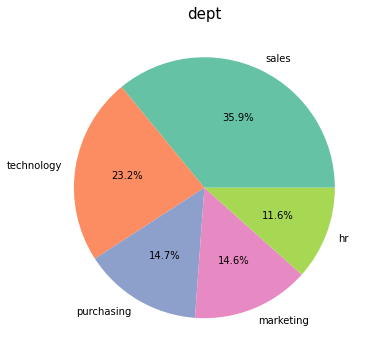

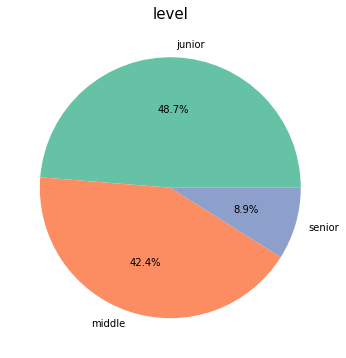

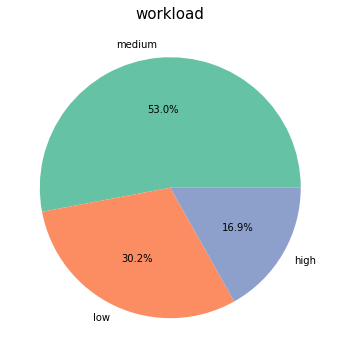

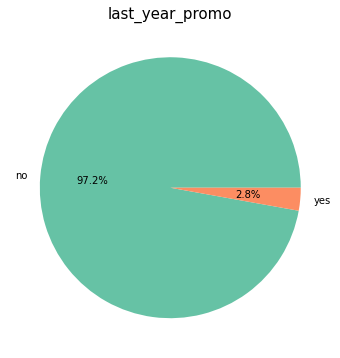

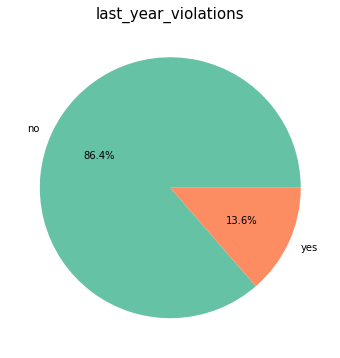

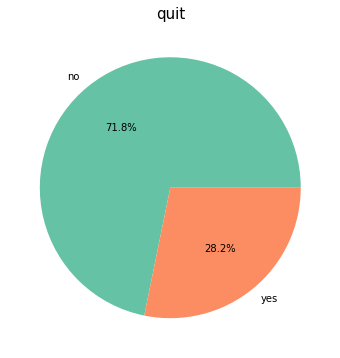

In [65]:
for i in cat_col:
    plt.figure(figsize=(6,6))
    plt.pie(train_quit[i].value_counts(), 
            labels=train_quit[i].value_counts().index,
            autopct='%1.1f%%',
            colors=plt.cm.Set2.colors
           )
    plt.title(i, fontsize=15)
    plt.show()

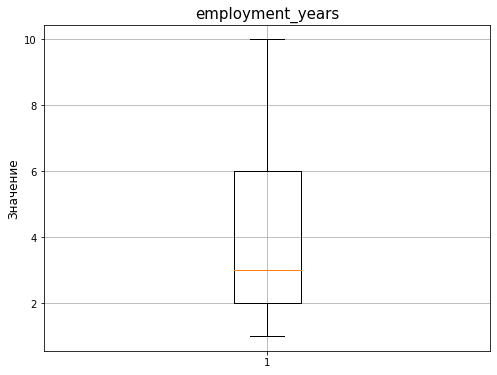

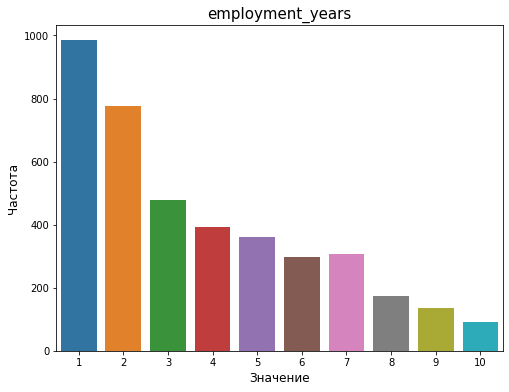

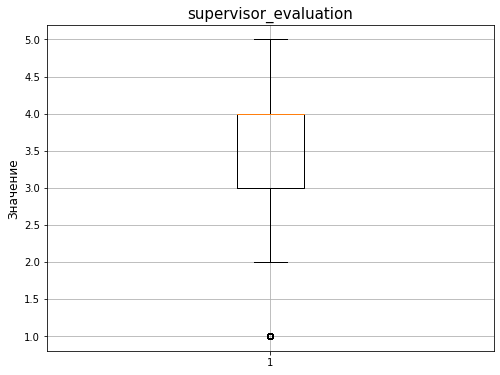

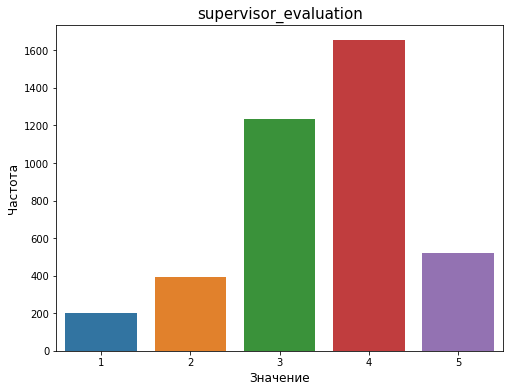

In [66]:
for i in discr_tq:
    plt.figure(figsize=(8,6))
    plt.boxplot(train_quit[i])
    plt.grid()
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.countplot(data=train_quit, x=i)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

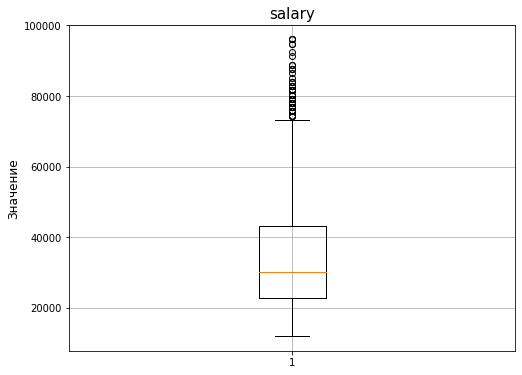

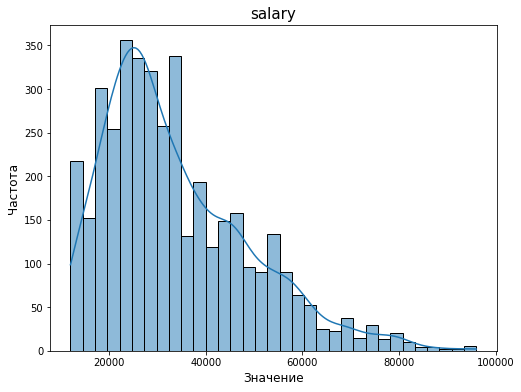

In [67]:
for i in cont_tq:
    plt.figure(figsize=(8,6))
    plt.boxplot(train_quit[i])
    plt.grid()
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.histplot(data=train_quit, x=i, kde=True)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

Датасет *test_target_quit*:

In [68]:
test_target_quit['quit'].describe()

count     2000
unique       2
top         no
freq      1436
Name: quit, dtype: object

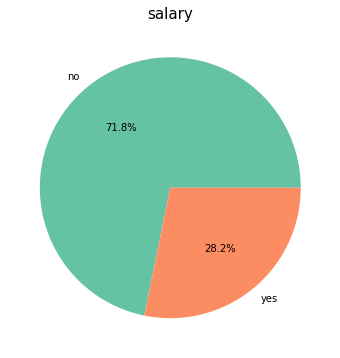

In [69]:
plt.figure(figsize=(6,6))
plt.pie(test_target_quit['quit'].value_counts(), 
    labels=test_target_quit['quit'].value_counts().index,
    autopct='%1.1f%%',
    colors=plt.cm.Set2.colors
    )
plt.title(i, fontsize=15)
plt.show()

Все распределения в датасетах аналогичны первой задаче. И в тренировочной, и в тестовой выборке, процент уволившихся сотрудников равен *28.2*. Попытаемся составить портрет уволившихся сотрудников, чтобы взглянуть на проблему более детально:

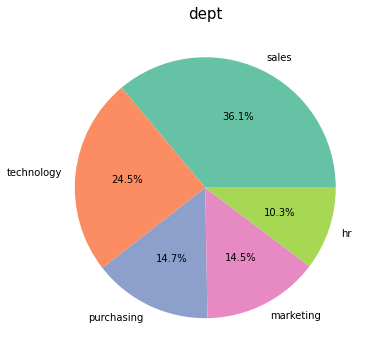

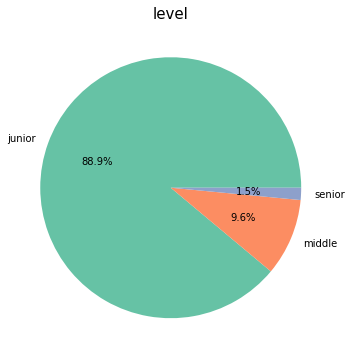

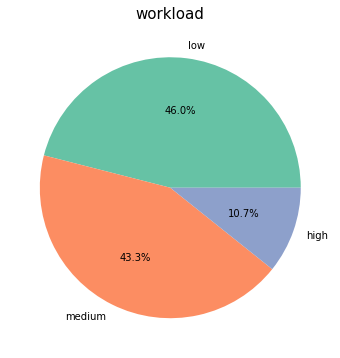

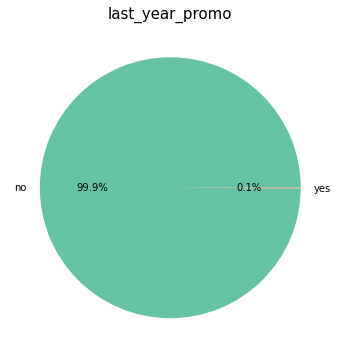

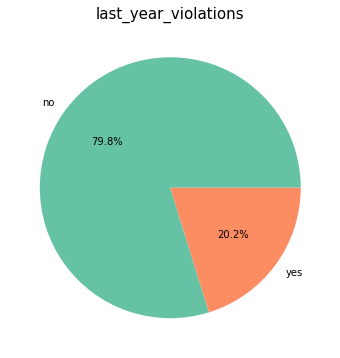

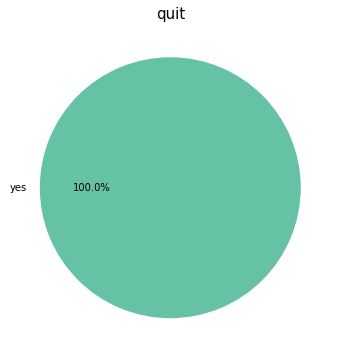

In [70]:
for i in cat_col:
    plt.figure(figsize=(6,6))
    plt.pie(train_quit.query('quit == "yes"')[i].value_counts(), 
            labels=train_quit.query('quit == "yes"')[i].value_counts().index,
            autopct='%1.1f%%',
            colors=plt.cm.Set2.colors
           )
    plt.title(i, fontsize=15)
    plt.show()

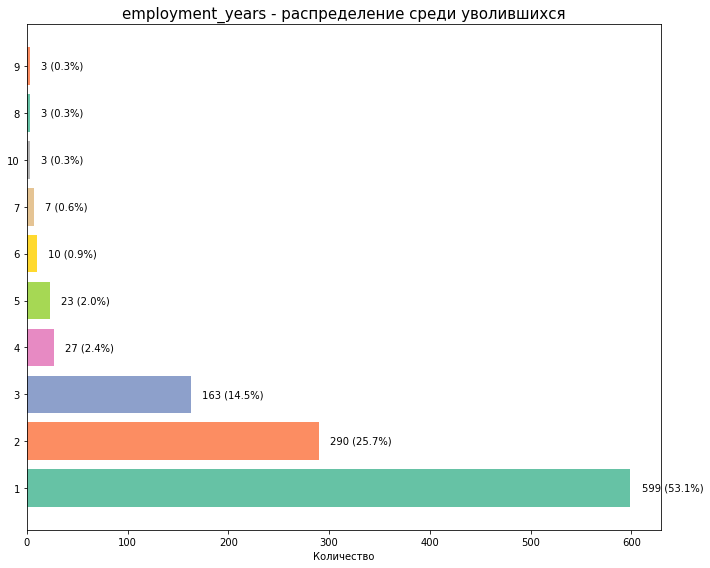

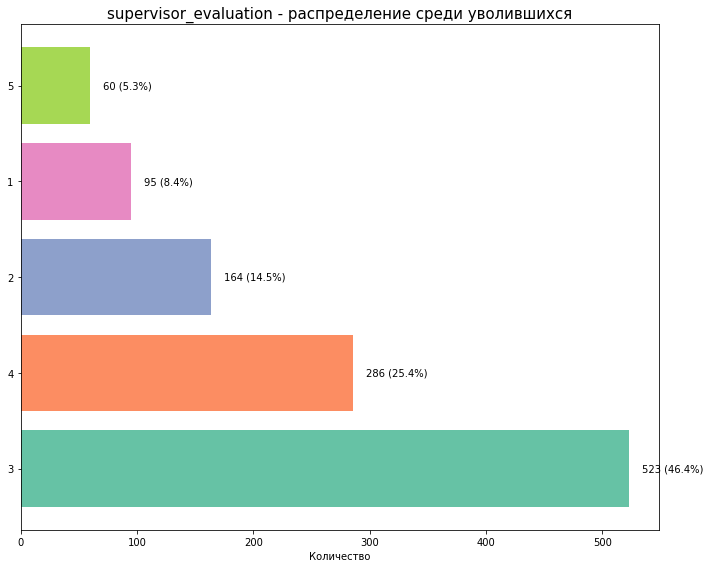

In [71]:
for i in discr_tq:
    plt.figure(figsize=(10, 8))
    
    # Данные
    data = train_quit.query('quit == "yes"')[i].value_counts()
    total = data.sum()
    
    # Создаем горизонтальные столбцы
    bars = plt.barh(data.index.astype(str), data.values, 
                   color=plt.cm.Set2.colors)
    
    # Добавляем проценты и значения
    for bar in bars:
        width = bar.get_width()
        percentage = (width / total) * 100
        plt.text(width + total * 0.01, bar.get_y() + bar.get_height()/2,
                f'{width} ({percentage:.1f}%)',
                va='center', fontsize=10)
    
    plt.xlabel('Количество')
    plt.title(f'{i} - распределение среди уволившихся', fontsize=15)
    plt.tight_layout()
    plt.show()

Сравним средние зарплаты уволившихся и оставшихся сотрудников:

In [72]:
print('Средняя зарплата уволившихся сотрудников:', train_quit.query('quit == "yes"')['salary'].mean(), '\n')
print('Средняя зарплата оставшихся сотрудников:', train_quit.query('quit == "no"')['salary'].mean())

Средняя зарплата уволившихся сотрудников: 23885.106382978724 

Средняя зарплата оставшихся сотрудников: 37702.22841225627


Что же, портрет ушедших сотрудников потихоньку начинает вырисовываться. 

Посмотрим на распределение признака удовлетворенности работой у ушедших и оставшихся:

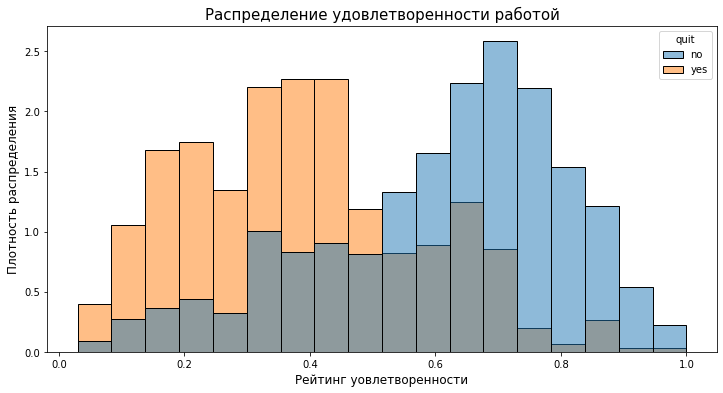

In [77]:
plt.figure(figsize=(12,6))
sns.histplot(data=test_target_job.merge(test_target_quit, on='id', how='left'),
            hue=test_target_job.merge(test_target_quit, on='id', how='left')['quit'],
            x=test_target_job.merge(test_target_quit, on='id', how='left')['job_satisfaction_rate'],
            stat='density', 
            common_norm=False
           )
plt.title('Распределение удовлетворенности работой', fontsize=15)
plt.xlabel('Рейтинг уовлетворенности', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12);

**Промежуточные выводы**:

Портрет ушедшего сотрудника:
- По распределению должностей, большинство работает в *продажах* и *технологическоих отделах*.
- Подавляющее большинство имеют уровень *junior*.
- Абсолютное большинство не получало повышения за прошлый год.
- Большинство проработало в компании всего год.
- Средняя оценка от руководителя - *3*.
- Средняя зарплата ушедших сотрудников составила *23885*, в то время как у оставшихся она равна *37702*, то есть в полтора раза больше.
- В среднем, рейтинг удовлетворенности работой у ушедших сотрудников меньше аж на *0.2* условных единицы. Поэтому, определенно, зависимость между уходом и удовлетворенностью существует.

<a id='merge'></a>
### Добавление предсказаний ко входным признакам.

Добавим предсказания, которые получим с помощью лучшей модели, ко входным признакам тестового датасета, чтобы повысить точность прогнозов:

In [72]:
test_features['JSR_predicted'] = predictions
test_features

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,JSR_predicted
0,485046,marketing,junior,medium,2,no,no,5,28800,0.871471
1,686555,hr,junior,medium,1,no,no,4,30000,0.662517
2,467458,sales,middle,low,5,no,no,4,19200,0.668714
3,418655,sales,middle,low,6,no,no,4,19200,0.647223
4,789145,hr,middle,medium,5,no,no,5,40800,0.810658
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.512040
1996,109582,technology,middle,low,3,no,no,2,21600,0.190233
1997,305653,technology,junior,low,1,no,no,3,14400,0.209862
1998,160233,technology,middle,low,8,no,no,1,32400,0.537512


In [73]:
train_quit['JSR_predicted'] = random_search.predict(train_quit.drop(['id', 'quit'], axis=1))
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,JSR_predicted
0,723290,sales,middle,high,2,no,no,4,54000,no,0.659098
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.841290
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.316869
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.343040
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.700726
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.507744
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.828610
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.549818
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.535403


Предсказания лучшей модели добавлены во входные признаки. Можно приступать к подготовке данных.

После добавления нового признака, снова проведем корреляционный анализ, чтобы убедиться, что мы не попортили данные:

In [74]:
train_quit.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,JSR_predicted
0,723290,sales,middle,high,2,no,no,4,54000,no,0.659098
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.841290
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.316869
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.343040
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.700726
5,699916,sales,junior,low,1,no,yes,3,18000,yes,0.170623
6,417070,technology,middle,medium,8,no,no,2,44400,no,0.370816
7,165489,sales,middle,low,4,no,no,5,19200,no,0.481295
8,996399,marketing,middle,low,7,no,no,4,25200,no,0.825568
9,613206,technology,middle,medium,2,no,no,3,45600,yes,0.371242


In [79]:
cont_tq.append('JSR_predicted')
cont_tq

['salary', 'JSR_predicted']

<AxesSubplot:>

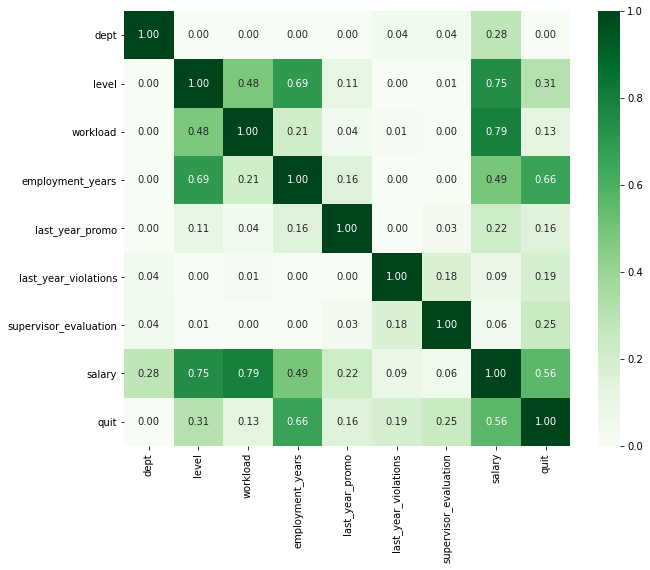

In [80]:
plt.figure(figsize=(10,8))
sns.heatmap(train_quit.drop(['id'], axis=1).phik_matrix(interval_cols=cont_tq),
           annot=True,
           fmt='.2f',
           cmap='Greens')

<AxesSubplot:>

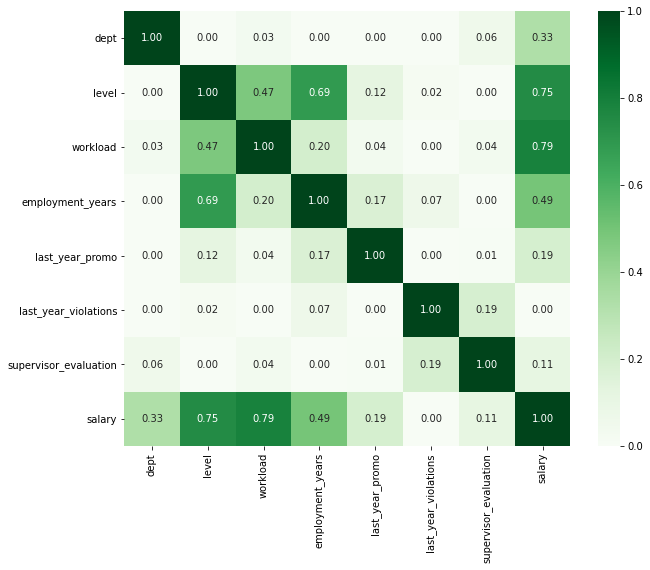

In [81]:
plt.figure(figsize=(10,8))
sns.heatmap(test_features.drop(['id'], axis=1).phik_matrix(interval_cols=cont_tq),
           annot=True,
           fmt='.2f',
           cmap='Greens')

Все в порядке, корреляции выше *0.9* не обнаружено, можем работать.

<a id='ml_prep2'></a>
### Подготовка данных к машинному обучению.

Все пайплайны уже есть, перепроверим:

In [79]:
train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit', 'JSR_predicted'],
      dtype='object')

In [80]:
print(ohe_columns, '\n', ord_columns, '\n', num_columns)

['dept'] 
 ['level', 'workload', 'last_year_promo', 'last_year_violations'] 
 Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object')


In [81]:
pipe_final_log = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [82]:
X1 = train_quit.drop(['id', 'quit'], axis=1)
y1 = train_quit['quit']

Закодируем целевой признак с помощью *LabelEncoder*:

In [96]:
le = LabelEncoder()
le.fit_transform(y1)

le.classes_

array(['no', 'yes'], dtype=object)

Делаем список для поиска оптимальных гиперпараметров:

In [97]:
param_grid_log = [
        {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,51),
        'models__max_features': range(1,51),
        'models__min_samples_leaf': range(1,51),
        'models__min_samples_split': range(1,51),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1,11),
        'preprocessoer__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5,51),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

<a id='mlearning2'></a>
### Обучение моделей.

Приступим к обучению моделей:

In [98]:
random_search_log = RandomizedSearchCV(
    pipe_final_log,
    param_grid_log,
    cv=5,
    random_state=RANDOM_STATE,
    scoring='roc_auc', 
    n_jobs=-1
)

In [99]:
warnings.filterwarnings('ignore')

random_search_log.fit(X1, y1)

print('Метрика ROC-AUC:', random_search_log.best_score_)
print('Лучшие параметры:', random_search_log.best_params_)

Метрика ROC-AUC: 0.9297727422903206
Лучшие параметры: {'preprocessor__num': 'passthrough', 'models__min_samples_split': 2, 'models__min_samples_leaf': 11, 'models__max_features': 15, 'models__max_depth': 14, 'models': DecisionTreeClassifier(max_depth=14, max_features=15, min_samples_leaf=11,
                       random_state=42)}


Посмотрим метрику на тестовой выборке:

In [90]:
display(test_target_quit.head())
test_features.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,JSR_predicted
0,485046,marketing,junior,medium,2,no,no,5,28800,0.871471
1,686555,hr,junior,medium,1,no,no,4,30000,0.662517
2,467458,sales,middle,low,5,no,no,4,19200,0.668714
3,418655,sales,middle,low,6,no,no,4,19200,0.647223
4,789145,hr,middle,medium,5,no,no,5,40800,0.810658


In [100]:
test1 = test_features.merge(test_target_quit, on='id', how='left')
le.transform(test1['quit'])
test1

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,JSR_predicted,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.871471,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.662517,no
2,467458,sales,middle,low,5,no,no,4,19200,0.668714,no
3,418655,sales,middle,low,6,no,no,4,19200,0.647223,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.810658,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.512040,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.190233,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.209862,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.537512,no


In [101]:
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(test1["quit"],  
                                            random_search_log.predict_proba(test1.drop(["id", "quit"], axis=1))[:,1]))

Метрика ROC-AUC на тестовой выборке: 0.9300534384322092


Теперь посмотрим на матрицу ошибок на тестовом датасете:

<Figure size 1440x1440 with 0 Axes>

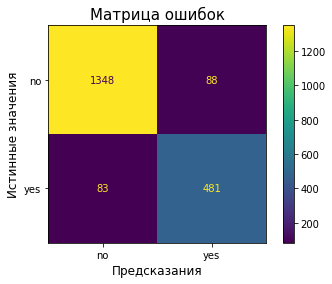

In [107]:
#y_pred = random_search_log.predict_proba(test1.drop(["id", "quit"], axis=1))[:,1]
cm = confusion_matrix(test1["quit"], random_search_log.predict(test1.drop(["id", "quit"], axis=1)))
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(cm, display_labels=random_search_log.classes_)
disp.plot()
plt.title('Матрица ошибок', fontsize=15)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Истинные значения', fontsize=12)
plt.show()

In [111]:
test1['quit']
random_search_log.predict(test1.drop(["id", "quit"], axis=1))

array(['no', 'no', 'no', ..., 'yes', 'no', 'no'], dtype=object)

In [117]:
print('Метрика accuracy:', accuracy_score(test1["quit"], random_search_log.predict(test1.drop(["id", "quit"], axis=1))))
print('Метрика recall:', recall_score(test1["quit"], random_search_log.predict(test1.drop(["id", "quit"], axis=1)),
     pos_label='yes'))
print('Метрика precision:', precision_score(test1["quit"], random_search_log.predict(test1.drop(["id", "quit"], axis=1)),
                                           pos_label='yes'))

Метрика accuracy: 0.9145
Метрика recall: 0.8528368794326241
Метрика precision: 0.8453427065026362


**Промежуточные выводы:**

Лучше всего из четырех моделей (логистическая регрессия, ближайшие соседи, опорные вектора, дерево решений) справилась модель дерева решений. Возможно, это случилось потому, что для деревьев можно подбирать большое число гиперпараметров и в большом диапазоне, что означает более тонкую настройку и, соответственно, лучший результат.

Метрика ROC-AUC, полученная при кросс-валидации: *0.93*.

Метрика ROC-AUC, полученная на тестовой выборке: *0.93*.

Анализ матрицы ошибок и другие метрики:
- Метрика accuracy: *0.91*.
- Метрика recall: *0.85*.
- Метрика precision: *0.84*.

Явные метрики матрицы ошибок:
- Всего оставшихся сотрудников: *1436*. Модель смогла правильно определить (**TrueNegative**, действительно остались) *1348* из них, неправильно предсказала (**FalsePositive**, остались, но модель предсказала, что уйдут) *88* (*6%* от общего числа оставшихся).
- Всего ушедших сотрудников: *564*. Модель смогла правильно определить (**TruePositive**, дейсвительно ушли) *481* из них, неправильно предсказала (**FalseNegative**, ушли, но модель предсказала, что останутся) *83* (*14%* от общего числа ушедших).

Все метрики показывают хороший результат. Точность - 91%, метрика *precision* - *0.84*, значит, положительным предсказаниям модели можно доверять. *recall* - *0.85*, то есть высокую долю реальных положительных предсказаний модель действительно верно обнаружила.

<a id='results'></a>
## Итоговые выводы.

В ходе проекта были решены две большие задачи - регрессии и классификации - по запросу компании "Работа с заботой". 

**Первая задача:**

В ходе первой задачи строилась модель, которая предсказала бы рейтинг удовлетворенности сотрудника сввоей работой (задача регрессии).

**Подгрузка и [предобработка данных](#prep1):**

После подгрузки стало видно, что данные достаточно чистые. Затем была выполнена предобработка данных. В датасетах *train_job* и *test_features* были обнаружены пропуски в столбцах должностей и уровня должности. В последствии они были заполнены в пайплайне. Столбец с оценкой удовлетворенности в датасетах *train_job* и *test_target_job* был приведен из строкового формата в числовой. Также, в датасете *test_features* были обнаружены неявные пропуски в виде пробелов, которые были заменены на неопределенное значение *np.nan* для последующего заполнения в пайплайне. Стоит упомянуть, что во всех датасетах была исправлена грамматическая ошибка *sinior* на *senior*.

**[Исследовательский анализ](#research1):**

Датасет *train_job*:

*Качественные признаки*:
- Больше всего людей работает в продажах, на втором месте технологи.
- Всего лишь 9% людей имеют уровень сеньора, уровни джуниор и миддл распределены почти поровну (*junior: 47.5%*, *middle: 43.6%*).
- Большинство людей имеют средний уровень загруженности.
- Только 3% людей получили повышение в прошлом году.
- 14% людей нарушали трудовой договор за прошедший год.

*Количественные дискретные признаки*:
- Средний срок работы в компании равен почти 4 годам, максимальный срок - 10 лет.
- Средняя оценка от руководителей составляет 3.5

*Количественные непрерывные признаки*:
- Средняя зарплата составляет почти 34 000, есть небольшое количество выбросов в большой зарплате, в районе 98 000 (полагаю, что это зарплата того маленького количества сеньоров).
- Средняя оценка удовлетворенности работой близка к 0.6, выбросов в очень маленькую или очень большую сторону не наблюдается.

Датасет *test_features*:
- Распределение всех признаков в датасете *test_features* аналогично распределению признаков в *train_job*/

Датасет *test_target_job*:
- Распределение аналогично соответствующему распределению в *train_job*.

**[Корреляционный анализ](#corr1):**

Видна корреляция между признаками, между которыми её и так можно было бы предположить: 
- Уровень должности коррелирует с количеством лет в компании и с зарплатой.
- Уровень нагрузки коррелирует с зарплатой.
- Есть сильная корреляция оценки от руководителя с целевым признаком удовлетворенности работой.

Однако, коэффициенты корреляции не превышали допустимые нормы, поэтому данные не были удалены.

Затем была выполнена **[подготовка данных](#ml_prep1)** к машинному обучению, созданы необходимые пайплайны и список для перебора моделей и гиперпараметров.

**[Обучение моделей](#mlearning1):**

Было обучено три модели: линейная регрессия, дерево решений и градиентный бустинг. Их надежность проверялась при помощи новой метрики SMAPE.
Лучшее значение SMAPE на кросс-валидации, которое было получено с помощью дерева решений: *17.86*. Ниже ее опустить не получалось никак, хоть и было перепробовано много сочетаний гиперпараметров. После чего был подключен ансамбль деревьев, который, разумеется, справился лучше - метрика SMAPE на кросс-валидации: *12.14*. 

Поиск гиперпараметров осуществлялся при помощи *RandomizedSearchCV*, для которого был создан словарик в разделе с [подготовкой данных](#ml_prep1).

**[Выводы по первой задаче](#results1):**

Как было показано выше, лучше всего справился ансамбль деревьев (*GradientBoostingRegressor*). Справилась она лучше остальных, думаю, по причине самого своего устройства - это много деревьев решений, каждое из которых обучается на ошибках предыдущего. Линейная регрессия справилась плохо потому, что подходит только для сильных линейных зависимостей, а данные с такими зависимостями, обычно, очень редки. Дерево решений справилось лучше, ее лучшая метрика, полученная на кросс-валидации, была равна *17.86* - хорошее значение, но оно все еще не подходило под условие задачи. 

Итоговая метрика лучшей модели на тестовой выборке: *11.68*. Остатки на тестовом датасете распределены нормально.

**Вторая задача:**

Вторая задача заключалась в том, чтобы предсказать, уйдет ли сотрудник из компании или нет (задача классификации).

В ходе подгрузки и [предобработки](#prep2) данных выяснилось, что они чистые и предобработки как таковой не требовали. Далее был проведен **[исследовательский анализ](#research2)**, который показал практически полностью аналогичные зависимости и распределения, как и в первой задаче. И в тренировочной, и в тестовой выборке, процент уволившихся сотрудников равен *28.2*.

Для более детального исследования был составлен портрет уволившегося сотрудника:
- По распределению должностей, большинство работает в *продажах* и *технологическоих отделах*.
- Подавляющее большинство имеют уровень *junior*.
- Абсолютное большинство не получало повышения за прошлый год.
- Большинство проработало в компании всего год.
- Средняя оценка от руководителя - *3*.
- Средняя зарплата ушедших сотрудников составила *23885*, в то время как у оставшихся она равна *37702*, то есть в полтора раза больше.
- В среднем, рейтинг удовлетворенности работой у ушедших сотрудников меньше аж на *0.2* условных единицы. Поэтому, определенно, зависимость между уходом и удовлетворенностью существует.

После того, как стало ясно, что есть четкая корреляция между уходом из компании и рейтингом удовлетворенности своей работой, этот признак, предсказанный с помощью лучшей модели из первой задачи, был [добавлен](#merge) к необходимым данным.

Затем, была выполнена аналогичная первой [подготовка данных к машинному обучению](#ml_prep2) и выполнено само [машинное обучение](#mlearning2). Лучше всего из четырех моделей (логистическая регрессия, ближайшие соседи, опорные вектора, дерево решений) справилась модель дерева решений. Возможно, это случилось потому, что для деревьев можно подбирать большое число гиперпараметров и в большом диапазоне, что означает более тонкую настройку и, соответственно, лучший результат.

Метрика ROC-AUC, полученная при кросс-валидации: *0.93*.

Метрика ROC-AUC, полученная на тестовой выборке: *0.93*.

Анализ матрицы ошибок и другие метрики:
- Метрика accuracy: *0.91*.
- Метрика recall: *0.85*.
- Метрика precision: *0.84*.

Явные метрики матрицы ошибок:
- Всего оставшихся сотрудников: *1436*. Модель смогла правильно определить (TrueNegative, действительно остались) *1348* из них, неправильно предсказала (FalsePositive, остались, но модель предсказала, что уйдут) *88* (*6%* от общего числа оставшихся).
- Всего ушедших сотрудников: *564*. Модель смогла правильно определить (TruePositive, дейсвительно ушли) *481* из них, неправильно предсказала (FalseNegative, ушли, но модель предсказала, что останутся) *83* (*14%* от общего числа ушедших).


Все метрики показывают хороший результат. Точность - 91%, метрика *precision* - *0.84*, значит, положительным предсказаниям модели можно доверять. *recall* - *0.85*, то есть высокую долю реальных положительных предсказаний модель действительно верно обнаружила.

Финальное предложения бизнесу:
- Более чутко следить за рейтингом удовлетворенности, если он оказывается в районе 0.4, то, при условии, что сотрудника нужно оставить, ему следует дать повышение или просто повысить зарплату, так как анализ показал, что у уволившихся зарплата аж в полтора раза ниже.
- Модели показали хорошие результаты, поэтому, для оптимизации вышеуказанного пункта, их можно смело внедрять в работу.